<a href="https://colab.research.google.com/github/SriNithin965/project-4-2/blob/main/code/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas==1.2.0
!pip install --upgrade xlrd

In [95]:
import pandas as pd
import numpy as np
import keras
from keras.layers import Dense
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.utils import np_utils
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler

In [96]:
data = pd.read_excel('https://github.com/SriNithin965/project-4-2/raw/main/data/Sample-Superstore.xls')

In [ ]:
data1 = data[['Ship Date','Sales']]
data1 = data1.groupby('Ship Date').sum()
data1 = data1.resample('MS').median()
data1.head(10)

In [ ]:
data1 = data1.reset_index()
data1

In [ ]:
data1.rename(columns={'Ship Date':'date','Sales':'sales'},inplace=True)
data1

In [ ]:
df_diff = data1.copy()
df_diff['prev_sales'] = df_diff['sales'].shift(1)
df_diff = df_diff.dropna()
df_diff['diff'] = (df_diff['sales'] - df_diff['prev_sales'])
df_diff.head(10)

In [102]:
df_supervised = df_diff.drop(['prev_sales'],axis=1)
for inc in range(1,13):
    field_name = 'lag_' + str(inc)
    df_supervised[field_name] = df_supervised['diff'].shift(inc)
df_supervised = df_supervised.dropna().reset_index(drop=True)

In [ ]:
df_supervised.head(10)

In [ ]:
len(df_supervised)

In [105]:
df_model = df_supervised.drop(['date','sales'],axis=1)
train_set, test_set = df_model[0:-6].values, df_model[-6:].values

In [106]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(train_set)
train_set = train_set.reshape(train_set.shape[0], train_set.shape[1])
train_set_scaled = scaler.transform(train_set)
test_set = test_set.reshape(test_set.shape[0], test_set.shape[1])
test_set_scaled = scaler.transform(test_set)

In [107]:
X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1]
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [ ]:
model = Sequential()
model.add(LSTM(4, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=1, shuffle=False)

In [ ]:
y_pred = model.predict(X_test,batch_size=1)
y_pred

In [ ]:
from sklearn import metrics
metrics.mean_absolute_error(y_test,y_pred)

In [ ]:
y_pred = y_pred.reshape(y_pred.shape[0], 1, y_pred.shape[1])
pred_test_set = []
for index in range(0,len(y_pred)):
    print(np.concatenate([y_pred[index],X_test[index]],axis=1))
    pred_test_set.append(np.concatenate([y_pred[index],X_test[index]],axis=1))
pred_test_set = np.array(pred_test_set)
pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])
pred_test_set_inverted = scaler.inverse_transform(pred_test_set)

In [112]:
result_list = []
sales_dates = list(data1[-7:].date)
act_sales = list(data1[-7:].sales)
for index in range(0,len(pred_test_set_inverted)):
    result_dict = {}
    result_dict['pred_value'] = int(pred_test_set_inverted[index][0] + act_sales[index])
    result_dict['date'] = sales_dates[index+1]
    result_list.append(result_dict)
df_result = pd.DataFrame(result_list)

In [125]:
data2 = data1.copy()
df_re = df_result.copy()
data2  = data2.set_index('date')
df_re = df_re.set_index('date')

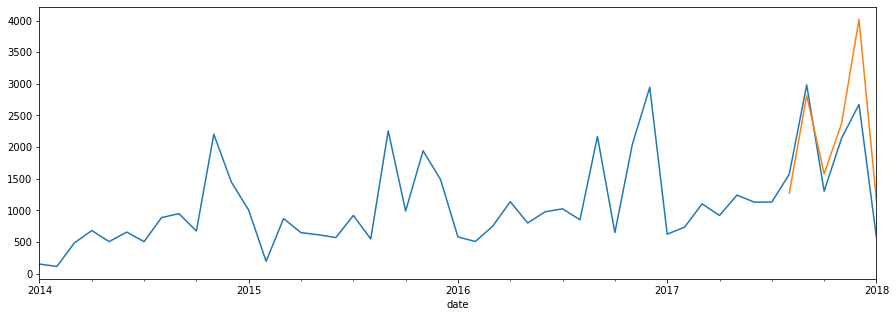

In [129]:
import matplotlib.pyplot as plt
data2['sales'].plot(figsize=(15,5))
df_re['pred_value'].plot()
plt.show()